In [53]:
import pandas as pd
import numpy as np

In [54]:
# Damped normalization

import numpy as np

def normalize(arr):
    normalized = arr / sum(arr)
    mean = 1 / len(arr)
    return normalized, mean

def damped_normalize(normalized, mean, alpha):
    damped = alpha * mean + (1 - alpha) * normalized
    return damped

def reverse_damped_normalize(damped, mean, alpha):
    original_normalized = (damped - alpha * mean) / (1 - alpha)
    return original_normalized

# Example usage
arr = np.array([10, 20, 30, 40, 50])
alpha = 0.8  # Damping factor

# Step 1: Normalize the original array
normalized, mean = normalize(arr)

# Step 2: Apply damped normalization
damped = damped_normalize(normalized, mean, alpha)

# Step 3: Reverse the damping to get the original normalized values
reversed_normalized = reverse_damped_normalize(damped, mean, alpha)

print("Original array:", arr)
print("Normalized:", normalized)
print("Damped Normalized:", damped)
print("Reversed Normalized:", reversed_normalized)


Original array: [10 20 30 40 50]
Normalized: [0.06666667 0.13333333 0.2        0.26666667 0.33333333]
Damped Normalized: [0.17333333 0.18666667 0.2        0.21333333 0.22666667]
Reversed Normalized: [0.06666667 0.13333333 0.2        0.26666667 0.33333333]


In [55]:
# Load in csv
df = pd.read_csv(r"../../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:1000,:]

In [56]:
class CoilNormalizer():
    def __init__(self):
        super(CoilNormalizer, self).__init__()
        self.max_change_df = None
        self.conserved_subgroups = None
    
    def max_absolute_change(self, df_diff):
        # Calculate the absolute change for each feature
        abs_change = df_diff.abs()

        # Find the maximum absolute change for each feature
        max_changes = abs_change.max()

        # Convert the series to a DataFrame
        max_change_df = max_changes.to_frame(name='Max Absolute Change')

        return max_change_df
    
    def damped_normalize(self,normalized, mean, alpha):
        damped = alpha * mean + (1 - alpha) * normalized
        return damped
    
    def reverse_damped_normalize(damped, mean, alpha):
        original_normalized = (damped - alpha * mean) / (1 - alpha)
        return original_normalized
    
    def normalize(self, df, damping_factor):
        # Calculate the change for each feature
        df_diff = df.diff()

        # Drop first row
        df_diff = df_diff.iloc[1:,:]
        
        # Calculate the max absolute change for each feature
        max_change_df = self.max_absolute_change(df_diff)

        normalized_features = []
        conserved_subgroups = {}
        count = 0
        index = 0
        for column in df_diff.columns:
            max_change_val = max_change_df.loc[column, 'Max Absolute Change']
            normalized_feature = (df_diff[column] + max_change_val) / (2 * max_change_val)
            
            normalized_counter = 1 - normalized_feature
            
            normalized_features.append(normalized_counter)
            normalized_features.append(normalized_feature)
            
            conserved_subgroups[index] = [count, count + 1]
            index += 1
            count += 2
            
        # Create dataframe
        normalized_df = pd.DataFrame(normalized_features).T
        
        # Normalize the dataframe again by row such that each row sums to 1
        renormalized_df = normalized_df.div(normalized_df.sum(axis=1), axis=0)
        
        # Now damp the normalization based on provided damping factor
        damped_normalized = damped_normalize(renormalized_df, mean = 1/renormalized_df.shape[1], alpha = damping_factor)
        
        self.max_change_df = max_change_df
        self.conserved_subgroups = conserved_subgroups
        self.damping_factor = damping_factor

        return damped_normalized
    
    def denormalize(self, damped_normalized_df, initial_value):
        # Remove damping factor
        normalized_df = reverse_damped_normalize(damped_normalized_df, mean = 1/ damped_normalized_df.shape[1], alpha = self.damping_factor)
        
        # For now assume there are even pairs
        denorm_dict = {}
        for key, value in self.conserved_subgroups.items():
            df_sel = normalized_df.iloc[:,value]
            denorm_dict[df_sel.columns[1]] = df_sel.div(df_sel.sum(axis=1), axis=0).iloc[:,1]
            
        denormalized_df = pd.DataFrame(denorm_dict, index=normalized_df.index)
        
        reconstructed_array = []
        new_value = initial_value
        reconstructed_array.append(initial_value)
        delta_max = self.max_change_df.iloc[:,0]
        for i in range(denormalized_df.shape[0]):
            delta_t = 2 * denormalized_df.iloc[i,:] * delta_max - delta_max
            new_value = new_value + delta_t
            reconstructed_array.append(new_value)
        return pd.DataFrame(reconstructed_array, index = [initial_value.name] + list(denormalized_df.index))

In [57]:
# Instantiate CoilNormalizer
coilnormer = CoilNormalizer()

coilnormed_df = coilnormer.normalize(df, damping_factor=0.0)
print(coilnormed_df)

                     p (mbar)  p (mbar)  T (degC)  T (degC)  Tpot (K)  \
Date Time                                                               
2009-01-01 00:20:00  0.029557  0.041872  0.045320  0.026108  0.045254   
2009-01-01 00:30:00  0.040640  0.030788  0.038177  0.033251  0.038160   
2009-01-01 00:40:00  0.038177  0.033251  0.030788  0.040640  0.030577   
2009-01-01 00:50:00  0.035714  0.035714  0.034729  0.036700  0.034980   
2009-01-01 01:00:00  0.036946  0.034483  0.030296  0.041133  0.030088   
...                       ...       ...       ...       ...       ...   
2009-01-07 22:00:00  0.022167  0.049261  0.019458  0.051970  0.019814   
2009-01-07 22:10:00  0.014778  0.056650  0.033005  0.038424  0.033268   
2009-01-07 22:20:00  0.011084  0.060345  0.050246  0.021182  0.050636   
2009-01-07 22:30:00  0.023399  0.048030  0.049261  0.022167  0.049413   
2009-01-07 22:40:00  0.020936  0.050493  0.045320  0.026108  0.045499   

                     Tpot (K)  Tdew (degC)  Tdew (

In [58]:
initial_value = df.iloc[0,:]
coilnormer.denormalize(coilnormed_df,initial_value)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-07 22:00:00,997.11,-9.41,263.97,-10.27,93.4,2.99,2.79,0.20,1.74,2.80,1315.59,0.52,1.38,188.1
2009-01-07 22:10:00,997.28,-9.30,264.07,-10.28,92.5,3.01,2.79,0.23,1.74,2.80,1315.27,0.29,1.13,85.4
2009-01-07 22:20:00,997.48,-9.89,263.46,-10.96,91.8,2.88,2.64,0.24,1.65,2.65,1318.56,0.29,1.00,119.3
2009-01-07 22:30:00,997.58,-10.44,262.90,-11.59,91.2,2.75,2.51,0.24,1.57,2.52,1321.51,0.55,1.00,130.5


In [59]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-07 22:00:00,997.11,-9.41,263.97,-10.27,93.4,2.99,2.79,0.20,1.74,2.80,1315.59,0.52,1.38,188.1
2009-01-07 22:10:00,997.28,-9.30,264.07,-10.28,92.5,3.01,2.79,0.23,1.74,2.80,1315.27,0.29,1.13,85.4
2009-01-07 22:20:00,997.48,-9.89,263.46,-10.96,91.8,2.88,2.64,0.24,1.65,2.65,1318.56,0.29,1.00,119.3


In [60]:
# We should be able to take any slice of the coilnormed timeseries and reproduce
start_index = 200
end_index = 300
df_orig_slice = df.iloc[start_index:end_index,:]
coilnormed_df_slice = coilnormed_df.iloc[start_index:end_index -1,:]
initial_value_slice = df.iloc[start_index,:]

denormed_slice = coilnormer.denormalize(coilnormed_df_slice,initial_value_slice)

In [61]:
import plotly.graph_objects as go
import pandas as pd

# Sample data creation
df1 = denormed_slice
df2 = df_orig_slice

# Plotting
fig = go.Figure()

# Add traces for the first dataframe
for column in df1.columns:
    fig.add_trace(go.Scatter(x=df2.index, y=df1[column], mode='lines', name=f'Denormed: {column}'))

# Add traces for the second dataframe
for column in df2.columns:
    fig.add_trace(go.Scatter(x=df2.index, y=df2[column], mode='lines', name=f'Orig: {column}'))

# Update layout
fig.update_layout(title='Interactive Time Series Plot',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  legend_title='Legend',
                  hovermode='x unified')

# Show the plot
fig.show()


In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LearnableTemperatureSoftmax(nn.Module):
    def __init__(self, initial_temperature=1.0, dim = -1):
        super(LearnableTemperatureSoftmax, self).__init__()
        self.dim = dim
        self.temperature = nn.Parameter(torch.tensor(initial_temperature))

    def forward(self, x):
        logits = x / self.temperature
        return F.softmax(logits, dim=self.dim)
    
class TemperatureSoftmax(nn.Module):
    def __init__(self, num_classes, temperature=1.0):
        super(TemperatureSoftmax, self).__init__()
        self.num_classes = num_classes
        self.temperature = temperature

    def forward(self, x):
        logits = x / self.temperature
        return F.softmax(logits, dim=-1)

class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features, n_batch, device = "cpu"):
        super(NeuralCoilLayer, self).__init__()
        self.interaction_tensors = nn.Parameter(torch.rand(n_features, n_features, n_features, n_features + 1))
        self.sel_temp = 1e-3
        self.norm_temp = n_features / 4
        
        starting_tensor = torch.softmax(torch.zeros(n_batch, n_features, n_features), dim = 1)
        if device == "cuda":
            self.starting_transition_tensor = starting_tensor.to("cuda")
        else:
            self.starting_transition_tensor = starting_tensor
            
    def select_transition_tensor(self, state_tensor,transition_tensor, interaction_tensor, sel_temperature):
        # Combine state and transition tensors into a norm_subgroups tensor
        norm_subgroups = torch.cat((state_tensor.unsqueeze(-1), transition_tensor), dim=2)
        
        # Get candidate transition tensors:
        candidate_transition_tensors = (torch.mul(interaction_tensor, norm_subgroups.unsqueeze(1).unsqueeze(1))).sum(-2) # [batches, states, states, states + 1]
        
        # Determine the largest and smallest states
        high_magnitude = torch.softmax(((state_tensor) / sel_temperature), dim = 1)
        low_magnitude = torch.softmax(1 - ((state_tensor) / sel_temperature), dim = 1)
        
        # Find which transition corresponds to moving from the highest state to the lowest state, and focus on that:
        transition_focus_slices = (torch.mul(torch.mul(candidate_transition_tensors, high_magnitude.unsqueeze(2).unsqueeze(1)), low_magnitude.unsqueeze(2).unsqueeze(2)))
        
        # Determine the selection weights by which slice is the highest in the focus transition
        selection_weights = torch.softmax(transition_focus_slices.sum(2).sum(1) / sel_temperature, dim = 1)
        
        # Perform weighted averaging
        selected_transition_tensor = torch.mul(candidate_transition_tensors, selection_weights.unsqueeze(1).unsqueeze(1)).sum(-1)
        
        return selected_transition_tensor
        
    def step_coil(self, state_tensor, transition_tensor):
        
        selected_transition_tensor = self.select_transition_tensor(state_tensor, transition_tensor, self.interaction_tensors, sel_temperature= self.sel_temp)
        
        selected_transition_tensor = torch.softmax(selected_transition_tensor * self.norm_temp, dim =1)
        
        new_state_tensor = torch.mul(selected_transition_tensor, state_tensor.unsqueeze(1)).sum(dim = -1)
        

        return new_state_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = self.starting_transition_tensor

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor

In [64]:
n_features = 16
batch, length, dim = 1, 64, n_features
x = torch.softmax(torch.randn(batch, length, dim), dim = 2)
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch=batch
)
y = model(x)


print(y[0].shape)
assert y[0].shape == x.shape
print(y[0].sum(dim = 2))

torch.Size([1, 64, 16])
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<SumBackward1>)


# Consistency Check

In [65]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch=batch
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch.randn(batch, n_features, n_features)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([-0.0381,  1.9097, -0.1267, -0.6538])
tensor([0.3009, 0.0660, 0.2189, 0.5053], grad_fn=<SliceBackward0>)
tensor([0.3009, 0.0660, 0.2189, 0.5053], grad_fn=<SliceBackward0>)


In [66]:
batch = 2
transition_tensor = transition_tensor[0:2,:,:]
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([0.3009, 0.0660, 0.2189, 0.5053], grad_fn=<SliceBackward0>)

In [67]:
def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)

In [68]:
# Generate and segment the time series
series = coilnormed_df.values
length = 36

series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x.to("cuda")
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y.to("cuda")

In [69]:
n_features = X.shape[2]

In [70]:
from torch import nn, optim

class CoilBlock(nn.Module):
    def __init__(self, n_features, n_batch, device):
        super(CoilBlock, self).__init__()

        self.coil1 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil2 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
        self.coil3 = NeuralCoilLayer(n_features = n_features, n_batch = n_batch, device= device)
    
    def forward(self, x):
        x, transition_tensor = self.coil1(x)
        x, transition_tensor = self.coil2(x)
        #x, transition_tensor = self.coil3(x)
        return x, transition_tensor
    
# Model
# Single Coil
model = NeuralCoilLayer(
    n_features = n_features,
    n_batch = X.shape[0],
    device="cuda"
).to("cuda")
# Coil Block
#model = CoilBlock(n_features=n_features, n_batch= X.shape[0], device="cuda").to("cuda")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 3000
best_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save the best model
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# Load the best model state after training
model.load_state_dict(best_model_state)
print("Best model loaded with loss:", best_loss)

Epoch [10/3000], Loss: 3.4067990782205015e-05
Epoch [20/3000], Loss: 3.180283965775743e-05
Epoch [30/3000], Loss: 3.0170798709150404e-05
Epoch [40/3000], Loss: 2.8965001547476277e-05
Epoch [50/3000], Loss: 2.8041960831615143e-05
Epoch [60/3000], Loss: 2.6945752324536443e-05
Epoch [70/3000], Loss: 2.572653829702176e-05
Epoch [80/3000], Loss: 2.4496759579051286e-05
Epoch [90/3000], Loss: 2.35969819186721e-05
Epoch [100/3000], Loss: 2.2580772565561347e-05
Epoch [110/3000], Loss: 2.1794443455291912e-05
Epoch [120/3000], Loss: 2.0806661268579774e-05
Epoch [130/3000], Loss: 1.9846607756335288e-05
Epoch [140/3000], Loss: 1.9244644136051647e-05
Epoch [150/3000], Loss: 1.978422915271949e-05
Epoch [160/3000], Loss: 1.8306187484995462e-05
Epoch [170/3000], Loss: 1.7294820281676948e-05
Epoch [180/3000], Loss: 1.6348807548638433e-05
Epoch [190/3000], Loss: 1.5560275642201304e-05
Epoch [200/3000], Loss: 1.4873206964693964e-05
Epoch [210/3000], Loss: 1.4226950952433981e-05
Epoch [220/3000], Loss: 1.3

In [71]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs.to("cpu"), Y.to("cpu"), batch_index=0, feature_index=1)

tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)


tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0000, device='c

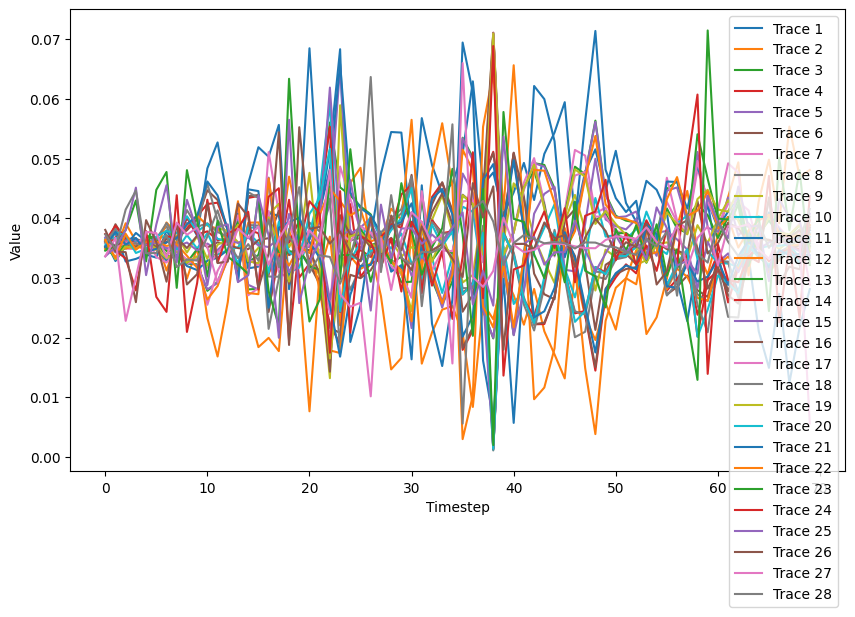

In [72]:
import matplotlib.pyplot as plt

states = []
batch = 15
state_tensor = X[:,0,:]
batch_size = X.shape[0]
transition_tensor = torch.softmax(torch.zeros(batch_size, n_features, n_features).to("cuda"), dim = 1)
for step_state in range(70):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    print(sum(state_tensor[batch,:]))
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

In [74]:
states = []
# Select the batch we want to make predictions for
batch = 13

# After what step do we want the coil to start making its own predictions?
prediction_step = 24

# What features do we want to plot?
feature_sel = [0,17]

# Grab starting state tensor
state_tensor = X[:,0,:]

# How many steps do we want to run the coil overall?
max_steps = 70

states.append(state_tensor[batch,feature_sel])
batch_size = X.shape[0]
transition_tensor = torch.softmax(torch.zeros(batch_size, n_features, n_features), dim = 1).to("cuda")
for step_state in range(1,max_steps):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    if step_state <= prediction_step:
        state_tensor = X[:,step_state,:]
    states.append(state_tensor[batch,feature_sel])

    
# Move state dynamics to CPU
data = [row.to('cpu').detach().numpy() for row in states]
traces = list(zip(*data))

# Create the figure and add traces
fig = go.Figure()

# Plotting
for i, trace in enumerate(traces):
    model_trace = go.Scatter(y=trace, mode='lines', name=f'Modelled Feature {feature_sel[i]}')
    fig.add_trace(model_trace)
    
    
# Get observed data to CPU and plot
data = X[batch,:,feature_sel].to('cpu')
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
for i, trace in enumerate(traces):
    obs_trace = go.Scatter(y=trace, mode='lines', name=f'Observed Feature {feature_sel[i]}')
    fig.add_trace(obs_trace)
    
# Add Line highlighting when the coil becomes responsible for its own predictions
fig.add_vline(x=prediction_step, line_width=3, line_dash="dash", line_color="grey", annotation_text='Point of Prediction')    

# Add title and labels
fig.update_layout(title=f'Coil Training Modelled vs Observed Comparison',
                    xaxis_title='Timestep',
                    yaxis_title='Value')

# Show the figure
fig.show()